In [172]:
%run Proyecto_idDrRecursos.ipynb

## **EXTRACCIÓN DE DATOS**

In [173]:
Freqs_drone = pd.read_json("Seleccion/Frecuencias/colFreqs1500.json")
label_drone = pd.read_csv("Seleccion/Frecuencias/labelFreqs1500.csv")
#Configuraciones para no truncar la salida  ***************
pd.set_option('display.max_rows', None)
#Porcentaje 50 
percent_query = 20
k = 5

In [174]:
#Datos 

#Query
nume_samples_query = int((len(Freqs_drone) * percent_query)/100)                       #Numero de muestras con respecto al porcentanje         
query_index_samples = random.sample(list(range(0,400)),nume_samples_query)          #Escogemos los indices de query aleatoriamente sin remplazo
query_index_samples.sort()                                                          #Ordenamos 
query_samples = Freqs_drone.iloc[query_index_samples]                                  #seleccionamos de data_num con respecto a los indices encontrados 
#Training
#Agregar inplace como True para eliminar de la original 
training_samples = Freqs_drone.drop(query_index_samples)                               #Escogemos los indices faltantes

#Label 
query_samples_label = label_drone.iloc[query_index_samples]                          #iloc -> [] usando los indices antes encontrados para query
training_samples_label = label_drone.drop(query_index_samples)                       #Escogemos los indices faltantes 

#Elementos en total 
total = len(query_samples)

## **PCA**

In [175]:
standard_scaler = StandardScaler()
normal_training = standard_scaler.fit_transform(training_samples)
normal_training = pd.DataFrame(normal_training, columns=training_samples.columns)
normal_training = normal_training.T

standard_scaler = StandardScaler()
normal_query = standard_scaler.fit_transform(query_samples)
normal_query = pd.DataFrame(normal_query, columns=query_samples.columns)

#PCA--------------------------------------------------------------------
#Dimension wine_normal_query -> (35, 13)
matrix_cov = np.cov(normal_training)
eigen_val, eigen_vec = np.linalg.eig(matrix_cov)
ind = np.argsort( eigen_val)[::-1]
eigen_vec_ord = eigen_vec[:, ind]
eigenvectores_visualizar = [0, 1, 2]
matriz_de_transformacion = eigen_vec_ord[:,eigenvectores_visualizar]
#La matriz_de_transformacion tiene las dimensiones de -> (13,3)
normal_training = normal_training.T
data_reducido_t = normal_training @ matriz_de_transformacion


In [176]:
data_reducido_q = normal_query @ matriz_de_transformacion

In [177]:
query_samples = data_reducido_q
training_samples = data_reducido_t

In [178]:
#training_samples
#query_samples

## **kNN**

In [179]:

#Elementos en total de la query
totalQ = len(query_samples)
totalT = len(training_samples)
size_q  = len(query_samples)                                                        #Size de query
k_DI = []  
cont_Error = 0
#Algoritmo kNN --------------------------------  
# query_samples_label.iloc[0]                                   #Aqui se almacenan las k distancias mas pequeñas                                                                          #

for j in range(size_q):  
    #print(j)                                                        #iteramos por todos los elementos de la query
    Q = np.tile(query_samples.iloc[j,:],(training_samples.shape[0],1))              #Igual que 'repmat'
    Z = Q - training_samples                                                        
    
    S_with_garbage = Z @ Z.T                                                        #puede usar tambien np.dot(m1,m2)
    distancia_S = np.diag(S_with_garbage) ** (1 / 2)                                #Obtener la diagonal y elevar sus elem a 1/2
    
    sort_index = np.argsort(distancia_S)                                            #Obtener los indices ordenados
    
    k_index = sort_index[:k]                                                        #Seleccionamos los k primeros
    k_dis = distancia_S[k_index]                                                    #Almacenamos las k distancias minimas

    mode_k_dis = mode(k_dis)[0]                                                     #mode retorna (moda, repeticiones)
    index_mode = np.where(distancia_S == mode_k_dis)[0][0]                        #buscamos indice en distancia_S de mode_k_dis
    k_DI.append(index_mode) 
    if query_samples_label.iloc[j,0] != training_samples_label.iloc[index_mode,0]:
        #print("Error:------------------------")
        #print(query_samples_label.iloc[j],"--",training_samples_label.iloc[index_mode])
        cont_Error += 1
    #else:
        #print("Success:------------------------")
        #print(query_samples_label.iloc[j],"--",training_samples_label.iloc[index_mode])


#print(cont_Error)
percent_success = (totalQ - cont_Error) * (100 / totalQ)
#return (totalQ, totalT, k, cont_Error, percent_success)

In [180]:
print(f"Errores: {cont_Error}")
percent_success = (total - cont_Error) * (100 / total)
print(f"Porcentaje query seleccionado: {percent_query}\n",
      f"Porcentaje training seleccionado: {100 - percent_query}\n",
      f"Elementos en query: {len(query_samples)}\n",
      f"Elementos en training: {len(training_samples)}\n",
      f"k : {k}\n",
      f"Porcentaje exito: {percent_success}\n",
      f"Total: {total-cont_Error}", sep="")

Errores: 8
Porcentaje query seleccionado: 20
Porcentaje training seleccionado: 80
Elementos en query: 80
Elementos en training: 320
k : 5
Porcentaje exito: 90.0
Total: 72


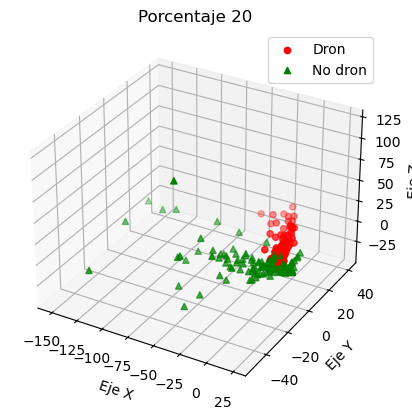

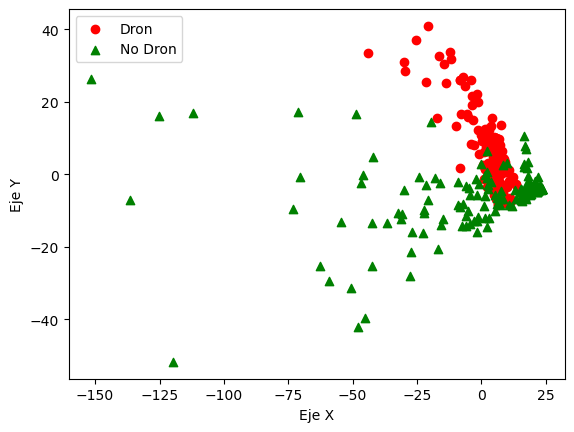

320


In [181]:

#Graficas-------------------------------------------------------------
freqs = training_samples_label.value_counts()
freqs = freqs.sort_index()
prim = freqs.iloc[0]


feature_ejex = 0
feature_ejey = 1
feature_ejez = 2


training_samples = training_samples.map(np.real)

#3D-----------------------------------------------------------
x_1 = (training_samples.iloc[:prim,feature_ejex]).to_list()
y_1 = (training_samples.iloc[:prim,feature_ejey]).to_list()
z_1 = (training_samples.iloc[:prim,feature_ejez]).to_list()

x_2 = (training_samples.iloc[prim:,feature_ejex]).to_list()
y_2 = (training_samples.iloc[prim:,feature_ejey]).to_list()
z_2 = (training_samples.iloc[prim:,feature_ejez]).to_list()


fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

# Graficar puntos para cada grupo con diferentes colores y marcadores
ax.scatter(x_1, y_1, z_1, c='r', marker='o', label='Dron')
ax.scatter(x_2, y_2, z_2, c='g', marker='^', label='No dron')


#Titulo
ax.set_title(f"Porcentaje query {percent_query}")
# Etiquetas de los ejes
ax.set_title(f"Porcentaje {percent_query}")
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
# Añadir leyenda
ax.legend()
# Mostrar gráfico
plt.show()

# Crear figura
plt.figure()

# Graficar puntos para cada grupo con diferentes colores y marcadores
plt.scatter(x_1, y_1, c='r', marker='o', label='Dron')
plt.scatter(x_2, y_2, c='g', marker='^', label='No Dron')


# Etiquetas de los ejes
plt.xlabel('Eje X')
plt.ylabel('Eje Y')

# Añadir leyenda
plt.legend()

# Mostrar gráfico
plt.show()
print(len(training_samples_label))